## YouTube's Inner World: A Data Exploration of Channel and Video Dynamics

Based on large-Scale channel and video Metadata from English-Speaking YouTube, we have a deep dive into this dataset. Featuring on time series analyzing, AI-based prediction, and ..., we explore, analyze, and concentrate the trends and characteristics of YouTube's channel. Insights are unlocked and shown at advanced visualization way.

#### Research Group
- `name`: Laughtodeath666
- `member`: ...

#### Dataset description
- `df_channels_en.tsv.gz`: contains data related to channel, category, join data, channel id & name, subscribers, rank, ect.
    - `category_cc`: category of the channel
    - `join_date`: join date of the channel
    - `channel`: channel id
    - `name_cc`: name of the channel
    - `subscribers_cc`: number of subscribers
    - `videos_cc`: number of videos
    - `subscriber_rank_sb`: rank in terms of number of subscribers
    - `weights`: weights cal
    - Note: 
        136,470 rows in total; 
        obtain it in 27/10/2019; 
        filter non-english channels.
- `df_timeseries_en.csv.gz`: latest category, datetime, views, subs, videos, and their changing amount.
    - `channel`: channel id
    - `category`: category according to the last 10 videos at time of crawl
    - `datetime`: week related to the data point
    - `views`: total number of views the channel had this week
    - `delta_views`: delta subscribers obtained this week
    - `subs`: total number of subscribers the channel had this week
    - `delta_subs`: rank in terms of number of subscribers
    - `videos`: total number of videos the channel had this week
    - `delta_videos`: delta videos obtained this week
    - `activity`: number of videos published in the last 15 days
    - Note: 18,872,499 data points belonging to 153,550 channels; 2.8 years of data for each channel in average; filter non-english channels; Data goes from early/01/2015 to end/09/2019 (incomplete time frame for some channels)
- `yt_metadata_en.jsonl.gz`: for each video of every channel, category, description, like/dislike counts, duration, tags, views, etc.
- `youtube_comments.tsv.gz`: anonymized user id, video id, replies, and likes received.

#### Our Tasks
- `Overall Profile Analysis`: Visualize the distributions, correlations, and trends of each features.
- `Duration Modeling and Analysis`: Taking multiple factors into account, model the duration-orientated comprehensive judging model.
- `YouTube channel strategies`: 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [15]:
# Import data
df_id= pd.read_csv('./data/channel_ids_sampled.csv')
df_channels = pd.read_feather('./data/df_channels_en_sampled.feather')
df_timeseries = pd.read_feather('./data/df_timeseries_en_sampled.feather')
df_comments = pd.read_feather('./data/num_comments_sampled.feather')
df_metadata = pd.read_feather('./data/yt_metadata_en_sampled.feather')

In [16]:
# View column names and data types of each dataframe
for df_name, df in [('df_id', df_id), 
                    ('df_channels', df_channels),
                    ('df_timeseries', df_timeseries), 
                    ('df_comments', df_comments),
                    ('df_metadata', df_metadata)]:
    print(f"\n{df_name} columns:")
    print(df.info())


df_id columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   channel  13633 non-null  object
dtypes: object(1)
memory usage: 106.6+ KB
None

df_channels columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category_cc         13633 non-null  object 
 1   join_date           13633 non-null  object 
 2   channel             13633 non-null  object 
 3   name_cc             13633 non-null  object 
 4   subscribers_cc      13633 non-null  int64  
 5   videos_cc           13633 non-null  int64  
 6   subscriber_rank_sb  13633 non-null  float64
 7   weights             13633 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 852.2+ KB
None

df_timeseries columns:
<clas

In [17]:
# Check missing values in each dataframe
display(pd.isna(df_id).sum())
display(pd.isna(df_channels).sum())
display(pd.isna(df_timeseries).sum())
display(pd.isna(df_comments).sum())
display(pd.isna(df_metadata).sum())

channel    0
dtype: int64

category_cc           0
join_date             0
channel               0
name_cc               0
subscribers_cc        0
videos_cc             0
subscriber_rank_sb    0
weights               0
dtype: int64

channel         0
category        0
datetime        0
views           0
delta_views     0
subs            0
delta_subs      0
videos          0
delta_videos    0
activity        0
dtype: int64

display_id    0
num_comms     0
dtype: int64

categories            0
channel_id            0
dislike_count    171758
display_id            0
duration              0
like_count       171758
upload_date           0
view_count           33
dtype: int64

We have identified the sources of missing/NaN data in each of our dataframes. The 'df_metadata' contains missing values in the 'dislike_count', 'like_count', and 'view_count' columns, with 171758 missing values in both 'dislike_count' and 'like_count', and 33 missing values in 'view_count'. All other dataframes have no missing values in any columns. Therefore, to address these missing values, we can fill them by calculating the mean based on 'channel_id'.

In [18]:
# fill missing values 
def fill_channel_means(df, columns_to_fill):
    """
    Fill NaN values in specified columns with the mean value of the same channel_id
    """
    # Create a copy to avoid modifying the original DataFrame
    df_filled = df.copy()
    
    # Calculate means for each channel_id
    channel_means = df.groupby('channel_id')[columns_to_fill].transform('mean')
    
    # Fill NaN values with channel means
    for col in columns_to_fill:
        df_filled[col] = df_filled[col].fillna(channel_means[col])
        
        # If any NaN values remain (for channels with all NaN values),
        # fill with the overall mean of the column
        if df_filled[col].isna().any():
            overall_mean = df[col].mean()
            df_filled[col] = df_filled[col].fillna(overall_mean)
    
    return df_filled

df_metadata=fill_channel_means(df_metadata, ['dislike_count','like_count' ,'view_count'])
display(pd.isna(df_metadata).sum())

categories       0
channel_id       0
dislike_count    0
display_id       0
duration         0
like_count       0
upload_date      0
view_count       0
dtype: int64

In [19]:
df_id.head(10)

,channel
0,UC8vVgIytHRD8aJeYINpG1kQ
1,UCxg6sQ9zDWu0b5DK0Ck9vjA
2,UCsAegdhiYLEoaFGuJFVrqFQ
3,UCPl2eZVyzL-qI9n8III1jRQ
4,UCkaBrf3FRFWxXg6FEfIjgUA
5,UCdOXRB936PKSwx0J7SgF6SQ
6,UCnUOLTxgO9C1I4cgj3GshAA
7,UCHVLKMhgZL5O08rjSx3QpQA
8,UC9sJElk83diXHdvVE8Fbz1A
9,UCb06PxivXgwX3qj1JEWmwrw


In [20]:
df_channels.head(10)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Autos & Vehicles,2006-07-21,UC8vVgIytHRD8aJeYINpG1kQ,vsandvs,11500,1055,838440.0,10.8730
1,Autos & Vehicles,2009-01-21,UCxg6sQ9zDWu0b5DK0Ck9vjA,V12 Productions,14100,274,737004.0,9.3105
2,Autos & Vehicles,2006-03-11,UCsAegdhiYLEoaFGuJFVrqFQ,MotorTrend Channel,6380000,2231,1160.0,2.0870
3,Autos & Vehicles,2010-08-02,UCPl2eZVyzL-qI9n8III1jRQ,Mercedes-Benz MYVAN,25780,304,471490.0,7.5720
4,Autos & Vehicles,2013-10-13,UCkaBrf3FRFWxXg6FEfIjgUA,fz09 dave,22000,92,519580.0,9.4240
5,Autos & Vehicles,2015-06-11,UCdOXRB936PKSwx0J7SgF6SQ,EddieX,84500,331,184399.0,4.5440
6,Autos & Vehicles,2008-08-30,UCnUOLTxgO9C1I4cgj3GshAA,SmallEngineMechanic,30100,292,398177.0,6.4970
7,Autos & Vehicles,2014-03-06,UCHVLKMhgZL5O08rjSx3QpQA,trailsoffroad.com,11200,1041,815295.0,12.0045
8,Autos & Vehicles,2015-12-17,UC9sJElk83diXHdvVE8Fbz1A,Money4yourMotors Lim...,10561,232,907859.0,15.3590
9,Autos & Vehicles,2012-10-02,UCb06PxivXgwX3qj1JEWmwrw,Galaxy89cars,25188,439,458635.0,8.8015


In [21]:
df_timeseries.head(10)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
714,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-01 00:00:00,1.530218e+07,13128.000,70608.625,0.000,92,0,1
715,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-08 00:00:00,1.532940e+07,27218.250,70709.500,100.875,93,1,2
716,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-15 00:00:00,1.535108e+07,21688.500,70794.250,84.750,93,0,1
717,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-22 00:00:00,1.539080e+07,39716.250,70936.000,141.750,94,1,1
718,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-08-29 00:00:00,1.541910e+07,28302.750,71038.375,102.375,94,0,1
719,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-09-05 00:00:00,1.545100e+07,31896.750,71117.500,79.125,94,0,0
720,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-09-12 00:00:00,1.537658e+07,0.000,71210.875,93.375,96,2,2
721,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-09-19 00:00:00,1.534019e+07,0.000,71301.000,90.125,96,0,2
722,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-09-26 00:00:00,1.536618e+07,25985.875,71377.625,76.625,97,1,2
723,UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2016-10-03 00:00:00,1.539366e+07,27485.375,71456.750,79.125,97,0,1


In [22]:
df_comments.head(10)

,display_id,num_comms
11303,aJUPKst0VWE,1.0
11304,1nD8xqURS_8,1.0
11305,JP8bObJpx7w,2.0
11306,CecDZi3WeSE,1.0
11307,ptBLjEa-TBM,1.0
11308,QMV0n63mJNk,3.0
11309,NhQro0dE1qA,0.0
11310,Ko7pe2Jyew8,0.0
11311,ECV9GeQozFM,0.0
11312,hAt7LbKA-sw,1.0


In [ ]:
df_metadata.head(10)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
0,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,3.0,aJUPKst0VWE,319,22.0,2019-09-09,384.0
1,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,0.0,1nD8xqURS_8,729,29.0,2019-09-08,591.0
2,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,8.0,JP8bObJpx7w,629,44.0,2019-08-27,1397.0
3,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,0.0,CecDZi3WeSE,496,28.0,2019-06-03,456.0
4,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,1.0,ptBLjEa-TBM,25,12.0,2019-06-02,323.0
5,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,4.0,QMV0n63mJNk,2235,26.0,2019-06-02,352.0
6,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,2.0,NhQro0dE1qA,764,30.0,2019-04-22,464.0
7,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,3.0,Ko7pe2Jyew8,2115,28.0,2019-04-17,574.0
8,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,3.0,ECV9GeQozFM,317,20.0,2019-04-17,331.0
9,Science & Technology,UCzWA3ov9kcza5XxtHh-lM7Q,3.0,hAt7LbKA-sw,96,16.0,2019-04-16,404.0


# Jack of all trades or master of one 
We wonder if YouTube creators should stick to one topic or mix it up. We can investigate this by analyzing three key aspects: the impact of content diversity on channel growth and engagement, long-term performance comparison between specialized and diversified channels, and common characteristics of successful diversification strategies

In [25]:
def preprocess_data(df_metadata, df_timeseries, min_videos=0):
    """Preprocess data, filter and aggregate in advance"""
    # 1. Calculate number of videos for each channel
    channel_video_counts = df_metadata['channel_id'].value_counts()
    
    # 2. Select channels that meet minimum video requirement
    valid_channels = channel_video_counts[channel_video_counts >= min_videos].index
    
    # 3. Filter data
    filtered_metadata = df_metadata[df_metadata['channel_id'].isin(valid_channels)].copy()
    filtered_timeseries = df_timeseries[df_timeseries['channel'].isin(valid_channels)].copy()
    
    return filtered_metadata, filtered_timeseries

def calculate_channel_metrics(filtered_metadata,filtered_timeseries):
    """Calculate channel metrics"""
    # Calculate basic metrics grouped by channel
    channel_metrics = filtered_metadata.groupby('channel_id').agg({
        'view_count': 'mean',
        'like_count': 'mean',
        'categories': lambda x: list(x)
    }).reset_index()
    
    # Calculate engagement rate
    channel_metrics['engagement_rate'] = channel_metrics['like_count'] / channel_metrics['view_count']
    
    # Calculate category distribution and diversity (information entropy) for each channel
    def calculate_diversity(categories):
        category_counts = pd.Series(categories).value_counts()
        proportions = category_counts / len(categories)
        return -np.sum(proportions * np.log(proportions))
    
    channel_metrics['diversity'] = channel_metrics['categories'].apply(calculate_diversity)
    channel_metrics['num_categories'] = channel_metrics['categories'].apply(lambda x: len(set(x)))
    channel_metrics['main_category'] = channel_metrics['categories'].apply(lambda x: pd.Series(x).mode()[0])
    channel_metrics['main_category_ratio'] = channel_metrics['categories'].apply(
        lambda x: pd.Series(x).value_counts().iloc[0] / len(x)
    )
    
    # Calculate growth metrics grouped by channel
    growth_metrics = df_timeseries.groupby('channel').agg({
        'delta_subs': ['sum', 'count'],  # Total growth and number of data points
        'delta_views': 'sum',
        'views': 'last',  # Latest views
        'subs': 'last'    # Latest subscribers
    })
    
    growth_metrics.columns = ['sub_growth', 'weeks', 'view_growth', 'final_views', 'final_subs']
    growth_metrics['weekly_sub_growth'] = growth_metrics['sub_growth'] / growth_metrics['weeks']
    growth_metrics['weekly_view_growth'] = growth_metrics['view_growth'] / growth_metrics['weeks']
    
    # Merge metrics
    merged_metrics = channel_metrics.merge(
        growth_metrics, 
        left_on='channel_id', 
        right_index=True,
        how='left'
    ).dropna()
    
    # Add channel strategy labels
    merged_metrics['strategy'] = pd.cut(
        merged_metrics['main_category_ratio'],
        bins=[0, 0.4, 0.7, 1],
        labels=['Diversified', 'Mixed', 'Specialized']
    )
    
    return merged_metrics


print("Preprocessing data...")
filtered_metadata, filtered_timeseries = preprocess_data(df_metadata, df_timeseries, 0)
    
print("Calculating channel metrics...")
merged_metrics = calculate_channel_metrics(filtered_metadata, filtered_timeseries)
print(merged_metrics.info())

Preprocessing data...
Calculating channel metrics...
<class 'pandas.core.frame.DataFrame'>
Index: 13345 entries, 0 to 13632
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   channel_id           13345 non-null  object  
 1   view_count           13345 non-null  float64 
 2   like_count           13345 non-null  float64 
 3   categories           13345 non-null  object  
 4   engagement_rate      13345 non-null  float64 
 5   diversity            13345 non-null  float64 
 6   num_categories       13345 non-null  int64   
 7   main_category        13345 non-null  object  
 8   main_category_ratio  13345 non-null  float64 
 9   sub_growth           13345 non-null  float64 
 10  weeks                13345 non-null  float64 
 11  view_growth          13345 non-null  float64 
 12  final_views          13345 non-null  float64 
 13  final_subs           13345 non-null  float64 
 14  weekly_sub_growth    1

In [27]:
def identify_patterns(merged_metrics, percentile=75):
    """Identify patterns of successful channels"""
    
    # Define multi-dimensional success thresholds
    view_threshold = merged_metrics['view_count'].quantile(percentile/100)
    engagement_threshold = merged_metrics['engagement_rate'].quantile(percentile/100)
    sub_growth_threshold = merged_metrics['weekly_sub_growth'].quantile(percentile/100)
    view_growth_threshold = merged_metrics['weekly_view_growth'].quantile(percentile/100)
    
    # Identify successful channels
    successful_channels = merged_metrics[
        (merged_metrics['view_count'] >= view_threshold) |
        (merged_metrics['engagement_rate'] >= engagement_threshold) |
        (merged_metrics['weekly_sub_growth'] >= sub_growth_threshold) |
        (merged_metrics['weekly_view_growth'] >= view_growth_threshold)
    ]
    
    # Calculate characteristics
    patterns = {
        'avg_diversity': successful_channels['diversity'].mean(),
        'avg_categories': successful_channels['num_categories'].mean(),
        'main_category_ratio': successful_channels['main_category_ratio'].mean(),
        'channel_count': len(successful_channels),
        'avg_views': successful_channels['view_count'].mean(),
        'avg_engagement': successful_channels['engagement_rate'].mean(),
        'avg_weekly_sub_growth': successful_channels['weekly_sub_growth'].mean(),
        'avg_weekly_view_growth': successful_channels['weekly_view_growth'].mean(),
        'avg_weeks_active': successful_channels['weeks'].mean(),
    }   
    
    # Analyze by strategy groups
    for strategy in successful_channels['strategy'].unique():
        strategy_channels = successful_channels[successful_channels['strategy'] == strategy]
        patterns[strategy] = {
            'proportion': len(strategy_channels) / len(successful_channels),
            'avg_weekly_sub_growth': strategy_channels['weekly_sub_growth'].mean(),
            'avg_weekly_view_growth': strategy_channels['weekly_view_growth'].mean(),
            'avg_diversity': strategy_channels['diversity'].mean()
        }
    
    print("\n=== Content Strategy Analysis Results ===")
    print(f"\nNumber of successful channels: {patterns['channel_count']}")
    print(f"Average diversity index: {patterns['avg_diversity']:.2f}")
    print(f"Average number of categories: {patterns['avg_categories']:.1f}")
    print(f"Average main category ratio: {patterns['main_category_ratio']*100:.1f}%")
    print(f"Average views: {patterns['avg_views']:,.0f}")
    print(f"Average engagement: {patterns['avg_engagement']:.3f}")
    print(f"Average weekly subscriber growth: {patterns['avg_weekly_sub_growth']:.1f}")
    print(f"Average weekly view growth: {patterns['avg_weekly_view_growth']:.1f}")
    print(f"Average active weeks: {patterns['avg_weeks_active']:.1f}")
    print("\nSuccessful Strategy Characteristics:")
    for strategy, stats in patterns.items():
        if isinstance(stats, dict):  # Ensure it's strategy data rather than other statistics
            print(f"\nStrategy: {strategy}")
            print(f"Proportion: {stats['proportion']:.1%}")
            print(f"Weekly average subscriber growth: {stats['avg_weekly_sub_growth']:.1f}")
            print(f"Weekly average view growth: {stats['avg_weekly_view_growth']:,.0f}")
            print(f"Content diversity: {stats['avg_diversity']:.2f}")
    
    return patterns, successful_channels

print("Identifying success patterns...")
patterns, successful_channels = identify_patterns(merged_metrics)

Identifying success patterns...

=== Content Strategy Analysis Results ===

Number of successful channels: 7471
Average diversity index: 0.33
Average number of categories: 2.8
Average main category ratio: 87.2%
Average views: 664,421
Average engagement: 0.024
Average weekly subscriber growth: 2422.2
Average weekly view growth: 676904.2
Average active weeks: 132.3

Successful Strategy Characteristics:

Strategy: Specialized
Proportion: 81.4%
Weekly average subscriber growth: 2530.7
Weekly average view growth: 717,751
Content diversity: 0.18

Strategy: Mixed
Proportion: 17.2%
Weekly average subscriber growth: 1988.3
Weekly average view growth: 507,182
Content diversity: 0.91

Strategy: Diversified
Proportion: 1.5%
Weekly average subscriber growth: 1478.0
Weekly average view growth: 396,569
Content diversity: 1.53


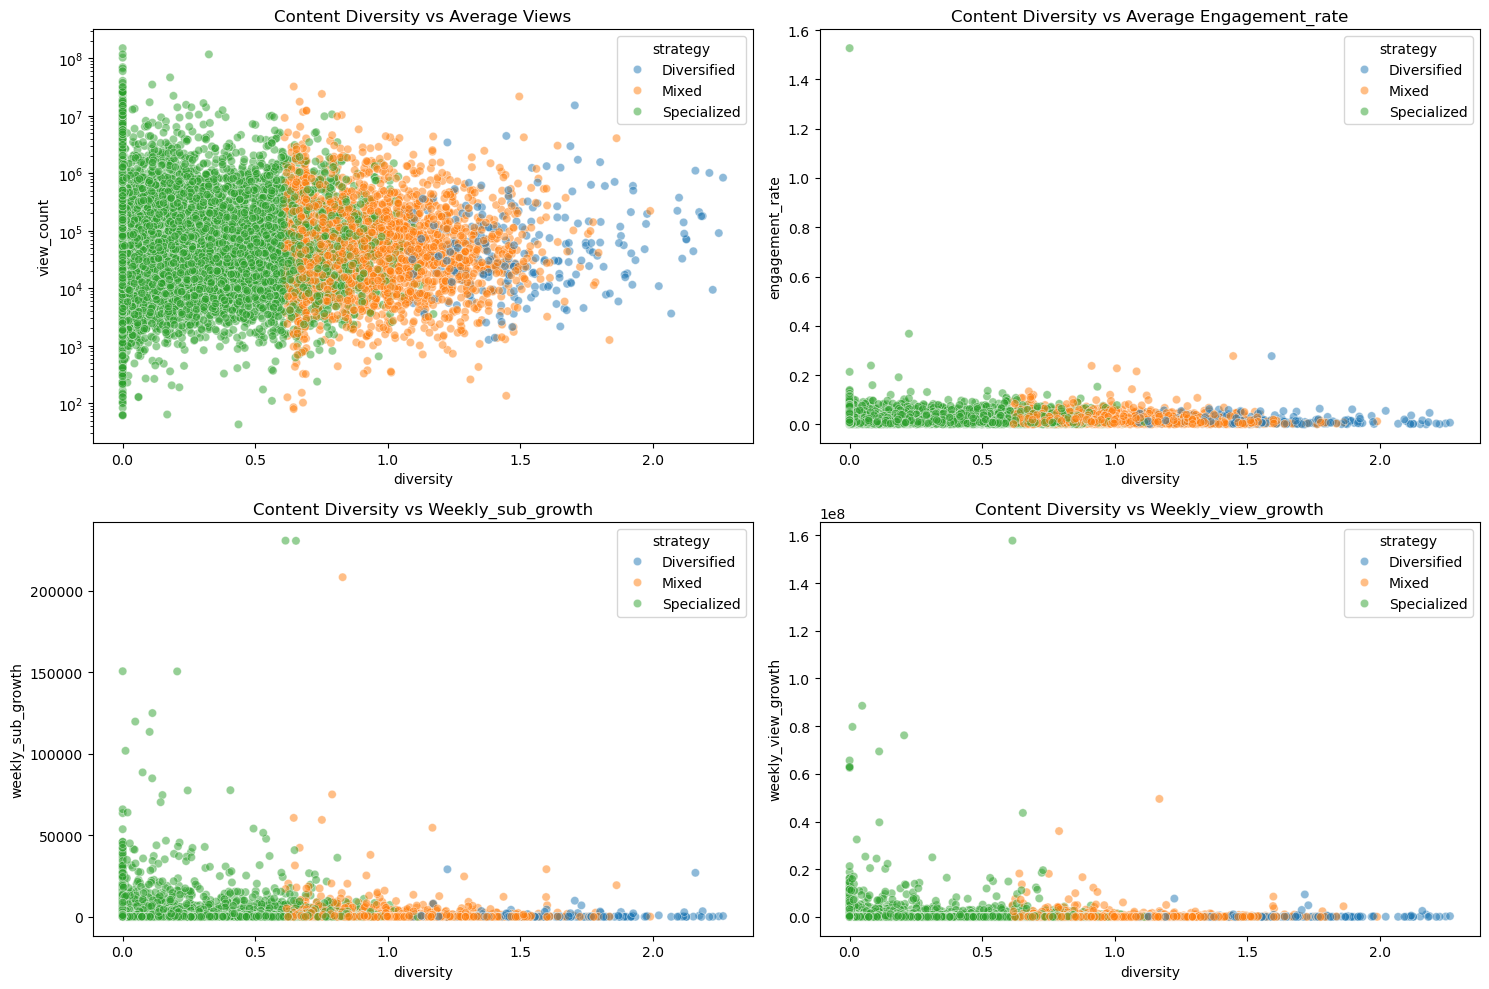

In [28]:
def diversity_plot_insights(merged_metrics):
    """Create key insight visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Diversity vs Views
    sns.scatterplot(
        data=merged_metrics,
        x='diversity',
        y='view_count',
        hue='strategy',
        alpha=0.5,
        ax=axes[0,0]
    )
    axes[0,0].set_title('Content Diversity vs Average Views')
    axes[0,0].set_yscale('log')  # Use log scale

    # 2. Number of categories vs Engagement
    sns.scatterplot(
        data=merged_metrics,
        x='diversity',
        y='engagement_rate',
        hue='strategy',
        alpha=0.5,
        ax=axes[0,1]
    )
    axes[0,1].set_title('Content Diversity vs Average Engagement_rate')

    # 3. Growth rate vs Diversity
    sns.scatterplot(
        data=merged_metrics,
        x='diversity',
        y='weekly_sub_growth',
        hue='strategy',
        alpha=0.5,
        ax=axes[1,0]
    )
    axes[1,0].set_title('Content Diversity vs Weekly_sub_growth')

    # 4. Main category ratio vs Growth rate
    sns.scatterplot(
        data=merged_metrics,
        x='diversity',
        y='weekly_view_growth',
        hue='strategy',
        alpha=0.5,
        ax=axes[1,1]
    )
    axes[1,1].set_title('Content Diversity vs Weekly_view_growth')

    plt.tight_layout()
    return fig


plot = diversity_plot_insights(merged_metrics)
plt.show()

In [31]:
# Perform  an analysis of variance to determine if there are significant differences between content strategies

# for View Count
f_view_count, p_view_count = stats.f_oneway(
    merged_metrics[merged_metrics['strategy'] == 'Diversified']['view_count'],
    merged_metrics[merged_metrics['strategy'] == 'Mixed']['view_count'],
    merged_metrics[merged_metrics['strategy'] == 'Specialized']['view_count']
)

# for Engagement Rate
f_engagement_rate, p_engagement_rate = stats.f_oneway(
    merged_metrics[merged_metrics['strategy'] == 'Diversified']['engagement_rate'],
    merged_metrics[merged_metrics['strategy'] == 'Mixed']['engagement_rate'],
    merged_metrics[merged_metrics['strategy'] == 'Specialized']['engagement_rate']
)

# for Weekly Subscriber Growth
f_sub_growth, p_sub_growth = stats.f_oneway(
    merged_metrics[merged_metrics['strategy'] == 'Diversified']['weekly_sub_growth'],
    merged_metrics[merged_metrics['strategy'] == 'Mixed']['weekly_sub_growth'],
    merged_metrics[merged_metrics['strategy'] == 'Specialized']['weekly_sub_growth']
)

# for Weekly View Growth
f_view_growth, p_view_growth = stats.f_oneway(
    merged_metrics[merged_metrics['strategy'] == 'Diversified']['weekly_view_growth'],
    merged_metrics[merged_metrics['strategy'] == 'Mixed']['weekly_view_growth'],
    merged_metrics[merged_metrics['strategy'] == 'Specialized']['weekly_view_growth']
)

# Display results
print("Analysis of Variance Results:")
print(f"View Count - F: {f_view_count}, p-value: {p_view_count}")
print(f"Engagement Rate - F: {f_engagement_rate}, p-value: {p_engagement_rate}")
print(f"Weekly Subscriber Growth - F: {f_sub_growth}, p-value: {p_sub_growth}")
print(f"Weekly View Growth - F: {f_view_growth}, p-value: {p_view_growth}")

Analysis of Variance Results:
View Count - F: 3.2724058590257874, p-value: 0.037945532790180155
Engagement Rate - F: 0.2712048262614672, p-value: 0.7624645117204254
Weekly Subscriber Growth - F: 5.139218011130636, p-value: 0.005873882517531403
Weekly View Growth - F: 3.1755525796979893, p-value: 0.04180258912049929


In the results shown above, we can observe the relationships between content diversity (`diversity`) and key channel performance metrics (`view count`, `engagement rate`, `subscriber growth`, and `view growth`), differentiated by content strategy (`Diversified`, `Mixed`, `Specialized`):

1. **Content Diversity vs. Average Views**: In the first chart, we can see that as content diversity increases, view counts exhibit some dispersion. Extremely high and low view counts are primarily found in channels with a Specialized strategy, while view counts for Diversified channels are relatively concentrated around a moderate level. The analysis of variance results indicate that content strategy has a significant effect on view counts, suggesting that more specialized channels may experience greater variability in view counts, with a higher potential for achieving very high views, whereas diversified channels tend to show more stable but moderate view counts.

2. **Content Diversity vs. Engagement Rate**: In the second chart, we observe a trend where engagement rate decreases as content diversity increases. High engagement rates are mostly seen in channels with a Specialized strategy, while Diversified channels tend to have lower engagement rates. However, The analysis of variance results show that the differences in engagement rate between strategies are not statistically significant, suggesting that while specialized content may promote viewer engagement, content strategy may not be the primary factor influencing engagement rates.

3. **Content Diversity vs. Weekly Subscriber Growth**: The third chart illustrates the relationship between subscriber growth and diversity. High subscriber growth is mostly seen in channels with Specialized and Mixed strategies, while Diversified channels generally show average performance in terms of subscriber growth. The analysis of variance results indicate a significant difference in weekly subscriber growth across strategies, suggesting that Specialized or Mixed strategies may be more conducive to subscriber growth.

4. **Content Diversity vs. Weekly View Growth**: The fourth chart shows a similar trend between view growth and diversity. Higher view growth is more common among Specialized channels, while Diversified channels tend to have lower view growth. The analysis of variance results also confirm a significant difference in weekly view growth across strategies, which may imply that channels focusing on specific content are better able to sustain viewer interest.

Through these observations and the analysis of variance results, we can conclude that there are significant differences in view count, weekly subscriber growth, and weekly view growth across content strategies, while engagement rate does not show a significant difference.

Next, we will analyze content strategy by main content category (`main_category`) to explore the relationships between diversity and performance within different categories.

In [35]:
# 1. Calculate mean and median for each content category
# Summarize diversity, view count, engagement rate, weekly subscriber growth, and weekly view growth
category_summary = merged_metrics.groupby('main_category').agg({
    'diversity': ['mean', 'median'],
    'view_count': ['mean', 'median'],
    'engagement_rate': ['mean', 'median'],
    'weekly_sub_growth': ['mean', 'median'],
    'weekly_view_growth': ['mean', 'median']
})

print("Mean and Median values for each content category:")
print(category_summary)

Mean and Median values for each content category:
                      diversity               view_count                 \
                           mean    median           mean         median   
main_category                                                             
Autos & Vehicles       0.349865  0.171262  134922.694631   42544.518603   
Comedy                 0.542463  0.495341  453019.340951  141088.934132   
Education              0.403180  0.308495  419967.044572   28820.963934   
Entertainment          0.455870  0.367649  489426.594136   72841.165766   
Film & Animation       0.488281  0.422937  338757.544792   72679.582399   
Gaming                 0.243602  0.071585  132098.621468   29099.781106   
Howto & Style          0.377202  0.248953  145717.769120   35736.544804   
Music                  0.218657  0.046340  978190.091255   90032.210377   
News & Politics        0.462077  0.338840   55436.983859   13843.081232   
Nonprofits & Activism  0.512612  0.440433   53151.

In [38]:
# 2. Calculate the proportion of each strategy within each content category
# Group by main_category and strategy to find strategy distribution within each category
category_strategy_distribution = merged_metrics.groupby(['main_category', 'strategy'],observed=True).size().unstack(fill_value=0)
category_strategy_distribution = category_strategy_distribution.div(category_strategy_distribution.sum(axis=1), axis=0)

print("Proportion of each strategy within each content category:")
print(category_strategy_distribution)

Proportion of each strategy within each content category:
strategy               Diversified     Mixed  Specialized
main_category                                            
Autos & Vehicles          0.020349  0.130814     0.848837
Comedy                    0.029178  0.294430     0.676393
Education                 0.024357  0.188092     0.787551
Entertainment             0.023810  0.250729     0.725462
Film & Animation          0.050847  0.262712     0.686441
Gaming                    0.007641  0.097300     0.895059
Howto & Style             0.012821  0.198291     0.788889
Music                     0.005887  0.093776     0.900336
News & Politics           0.028037  0.219626     0.752336
Nonprofits & Activism     0.032609  0.282609     0.684783
People & Blogs            0.016966  0.220060     0.762974
Pets & Animals            0.017391  0.200000     0.782609
Science & Technology      0.021142  0.209302     0.769556
Sports                    0.015326  0.134100     0.850575
Travel & Event

In [39]:
# 3. Perform an Analysis of Variance for each content category
# Conduct the analysis on each main_category to determine if strategies differ significantly within the category
analysis_variance_results = {}

for category in merged_metrics['main_category'].unique():
    data = merged_metrics[merged_metrics['main_category'] == category]
    
    f_view, p_view = stats.f_oneway(
        data[data['strategy'] == 'Diversified']['view_count'],
        data[data['strategy'] == 'Mixed']['view_count'],
        data[data['strategy'] == 'Specialized']['view_count']
    )
    f_engagement, p_engagement = stats.f_oneway(
        data[data['strategy'] == 'Diversified']['engagement_rate'],
        data[data['strategy'] == 'Mixed']['engagement_rate'],
        data[data['strategy'] == 'Specialized']['engagement_rate']
    )
    f_sub_growth, p_sub_growth = stats.f_oneway(
        data[data['strategy'] == 'Diversified']['weekly_sub_growth'],
        data[data['strategy'] == 'Mixed']['weekly_sub_growth'],
        data[data['strategy'] == 'Specialized']['weekly_sub_growth']
    )
    f_view_growth, p_view_growth = stats.f_oneway(
        data[data['strategy'] == 'Diversified']['weekly_view_growth'],
        data[data['strategy'] == 'Mixed']['weekly_view_growth'],
        data[data['strategy'] == 'Specialized']['weekly_view_growth']
    )
    
    # Store results for each category
    analysis_variance_results[category] = {
        'view_count': (f_view, p_view),
        'engagement_rate': (f_engagement, p_engagement),
        'weekly_sub_growth': (f_sub_growth, p_sub_growth),
        'weekly_view_growth': (f_view_growth, p_view_growth)
    }

# Display results
print("The Analysis of Variance Results for each content category:")
for category, results in analysis_variance_results.items():
    print(f"Category: {category}")
    print(f"View Count - F: {results['view_count'][0]}, p-value: {results['view_count'][1]}")
    print(f"Engagement Rate - F: {results['engagement_rate'][0]}, p-value: {results['engagement_rate'][1]}")
    print(f"Weekly Subscriber Growth - F: {results['weekly_sub_growth'][0]}, p-value: {results['weekly_sub_growth'][1]}")
    print(f"Weekly View Growth - F: {results['weekly_view_growth'][0]}, p-value: {results['weekly_view_growth'][1]}")

The Analysis of Variance Results for each content category:
Category: Music
View Count - F: 0.9427522289775784, p-value: 0.38969994685105347
Engagement Rate - F: 0.5446940424891826, p-value: 0.5800916574170735
Weekly Subscriber Growth - F: 1.3881207862294842, p-value: 0.2497461941208197
Weekly View Growth - F: 0.9101249359118911, p-value: 0.40261426082578977
Category: Gaming
View Count - F: 3.6395259676124128, p-value: 0.026442455061878232
Engagement Rate - F: 0.6132246752776209, p-value: 0.5417054389560132
Weekly Subscriber Growth - F: 0.47862322339718655, p-value: 0.619708307272594
Weekly View Growth - F: 0.1248112132134725, p-value: 0.8826705367995671
Category: Education
View Count - F: 0.7566929093293271, p-value: 0.4695802790616572
Engagement Rate - F: 2.66649718425798, p-value: 0.07016659112765032
Weekly Subscriber Growth - F: 2.464303667577017, p-value: 0.08576972054816286
Weekly View Growth - F: 0.7129300942072666, p-value: 0.49054395001428774
Category: Film & Animation
View Co

In [41]:
# Initialize dictionaries to store significant and non-significant results
significant_results = {}
non_significant_results = {}

# Iterate through results above to categorize based on p-value
for category, results in analysis_variance_results.items():
    significant_results[category] = {}
    non_significant_results[category] = {}
    
    for metric, (f_value, p_value) in results.items():
        if p_value < 0.05:
            significant_results[category][metric] = (f_value, p_value)
        else:
            non_significant_results[category][metric] = (f_value, p_value)

# Display significant and non-significant results
print("Significant Results (p < 0.05):")
for category, metrics in significant_results.items():
    if metrics:
        print(f"Category: {category}")
        for metric, (f_value, p_value) in metrics.items():
            print(f"{metric} - F: {f_value:.2f}, p-value: {p_value:.4f}")

print("Non-Significant Results (p >= 0.05):")
for category, metrics in non_significant_results.items():
    if metrics:
        print(f"Category: {category}")
        for metric, (f_value, p_value) in metrics.items():
            print(f"{metric} - F: {f_value:.2f}, p-value: {p_value:.4f}")

Significant Results (p < 0.05):
Category: Gaming
view_count - F: 3.64, p-value: 0.0264
Category: Comedy
view_count - F: 4.32, p-value: 0.0139
weekly_sub_growth - F: 3.70, p-value: 0.0256
weekly_view_growth - F: 3.31, p-value: 0.0376
Category: Howto & Style
view_count - F: 7.99, p-value: 0.0004
Category: Autos & Vehicles
engagement_rate - F: 4.08, p-value: 0.0177
Category: Travel & Events
weekly_sub_growth - F: 4.41, p-value: 0.0135
Non-Significant Results (p >= 0.05):
Category: Music
view_count - F: 0.94, p-value: 0.3897
engagement_rate - F: 0.54, p-value: 0.5801
weekly_sub_growth - F: 1.39, p-value: 0.2497
weekly_view_growth - F: 0.91, p-value: 0.4026
Category: Gaming
engagement_rate - F: 0.61, p-value: 0.5417
weekly_sub_growth - F: 0.48, p-value: 0.6197
weekly_view_growth - F: 0.12, p-value: 0.8827
Category: Education
view_count - F: 0.76, p-value: 0.4696
engagement_rate - F: 2.67, p-value: 0.0702
weekly_sub_growth - F: 2.46, p-value: 0.0858
weekly_view_growth - F: 0.71, p-value: 0.4

In the above analysis, we have divided the results into two groups: significant and non-significant.

**Significant Results (p < 0.05):**

In these categories and metrics, the differences between strategies are significant. This indicates that in these specific categories, content strategy (Diversified, Mixed, Specialized) has a noticeable impact on metrics such as view count, engagement rate, and subscriber growth. For example, in the Gaming category’s view count and several metrics in the Comedy category, strategy has a clear effect on performance. This suggests that selecting the appropriate strategy in these categories can significantly improve performance.

**Non-Significant Results (p >= 0.05):**

In these categories and metrics, the differences between strategies are not significant, indicating that content strategy has a smaller or negligible impact on these metrics. For example, in the Music and Education categories, all metrics have p-values greater than 0.05, suggesting that differences in performance between strategies are not significant. In these categories, content strategy may not be the primary factor influencing performance, and other factors (such as content quality or audience demand) might be more important.

Next, further analyze the specific performance of different strategies for categories and metrics with significant differences to identify the optimal strategy combinations.

In [44]:
# Dictionary to store mean values only for significant categories and metrics
significant_means = {}

# Iterate through significant categories and metrics
for category, metrics in significant_results.items():
    category_data = merged_metrics[merged_metrics['main_category'] == category]
    category_means = {}
    
    # Calculate mean values for each metric within each strategy, using observed=True to silence the warning
    for metric in metrics.keys():  # Only process significant metrics
        means = category_data.groupby('strategy', observed=True)[metric].mean()  # Add observed=True here
        category_means[metric] = means
    
    # Only add categories with available means to the final results
    if category_means:
        significant_means[category] = category_means

# Print only non-empty categories with significant metrics
print("\nMean values for significant categories and metrics by strategy:")
for category, metrics in significant_means.items():
    print(f"\nCategory: {category}")
    for metric, means in metrics.items():
        print(f"{metric} - Mean values by strategy:")
        print(means)


Mean values for significant categories and metrics by strategy:

Category: Gaming
view_count - Mean values by strategy:
strategy
Diversified    113901.213431
Mixed          209409.111308
Specialized    123849.707160
Name: view_count, dtype: float64

Category: Comedy
view_count - Mean values by strategy:
strategy
Diversified    174804.569499
Mixed          215066.261533
Specialized    568600.338211
Name: view_count, dtype: float64
weekly_sub_growth - Mean values by strategy:
strategy
Diversified     551.666367
Mixed          1103.667565
Specialized    2468.577835
Name: weekly_sub_growth, dtype: float64
weekly_view_growth - Mean values by strategy:
strategy
Diversified    124007.375820
Mixed          173245.377820
Specialized    640325.729518
Name: weekly_view_growth, dtype: float64

Category: Howto & Style
view_count - Mean values by strategy:
strategy
Diversified    542310.295963
Mixed          122424.318690
Specialized    145127.511912
Name: view_count, dtype: float64

Category: Auto

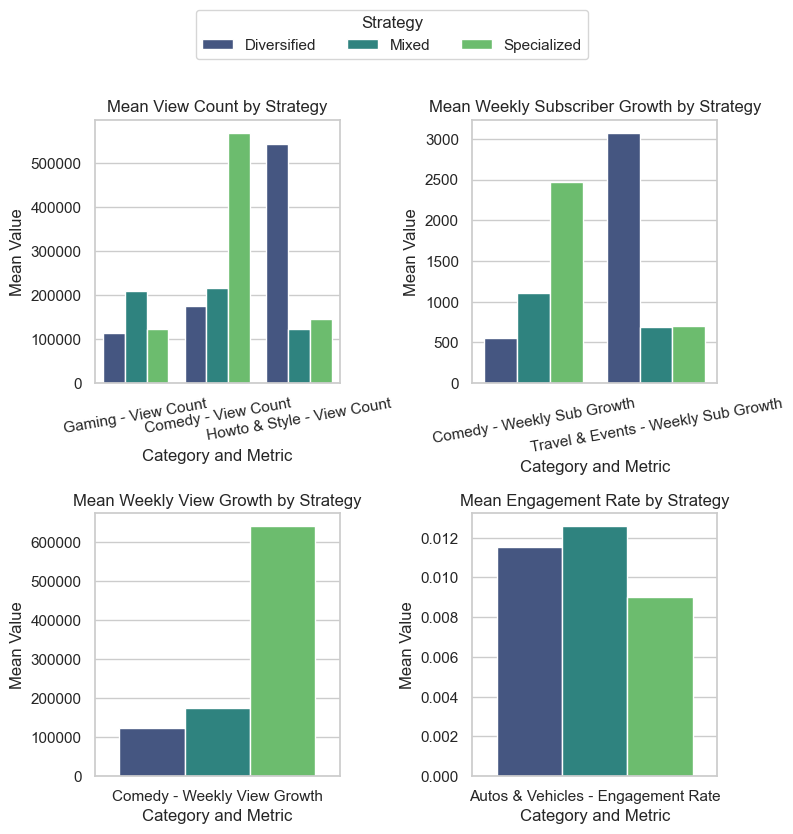

In [67]:
# Creating a DataFrame with significant categories and metrics
plot_data = []
for category, metrics in significant_means.items():
    for metric, mean_values in metrics.items():
        for strategy, mean_value in mean_values.items():
            plot_data.append({
                'Category_Metric': f"{category} - {metric.replace('_', ' ').title()}",
                'Strategy': strategy,
                'Mean Value': mean_value,
                'Metric': metric
            })

plot_df = pd.DataFrame(plot_data)

metrics_to_plot = ["view_count", "weekly_sub_growth", "weekly_view_growth", "engagement_rate"]
titles = {
    "view_count": "Mean View Count by Strategy",
    "weekly_sub_growth": "Mean Weekly Subscriber Growth by Strategy",
    "weekly_view_growth": "Mean Weekly View Growth by Strategy",
    "engagement_rate": "Mean Engagement Rate by Strategy"
}

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten() 

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(
        data=plot_df[plot_df["Metric"] == metric], 
        x="Category_Metric", y="Mean Value", hue="Strategy", palette="viridis", ax=axes[i]
    )
    axes[i].set_title(titles[metric])
    axes[i].set_xlabel("Category and Metric")
    axes[i].set_ylabel("Mean Value")
    
    # Rotate x-axis labels only for "view_count" and "weekly_sub_growth"
    if metric in ["view_count", "weekly_sub_growth"]:
        axes[i].tick_params(axis='x', rotation=10)
    
    axes[i].legend_.remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Strategy", loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

**Specialized Strategy**: Suitable for the Comedy channel, where audiences prefer specific content styles. Using a specialized strategy can effectively increase view counts and subscriber growth.

**Mixed Strategy**: Suitable for Gaming and Autos & Vehicles channels, which need a balance between diversity and focus to attract a broader audience.

**Diversified Strategy**: Suitable for Howto & Style and Travel & Events channels, where audiences have a high demand for diverse content. A diversified strategy can attract more audience interest.

# Analysis of video duration
We are interested in the impact of video duration. Will people prefer a longer video as they may get more knowledge, or they prefer a short video for passing time? We can explore this by investigating three aspects: optimal video length for different categories, the impact of video length on viewer engagement and channel growth, and the evolution of audience preferences for video length over time. Also, we are going to develop a method to evaluate the popular degree of a video, then focus on the relationship between video duration and popular degree.


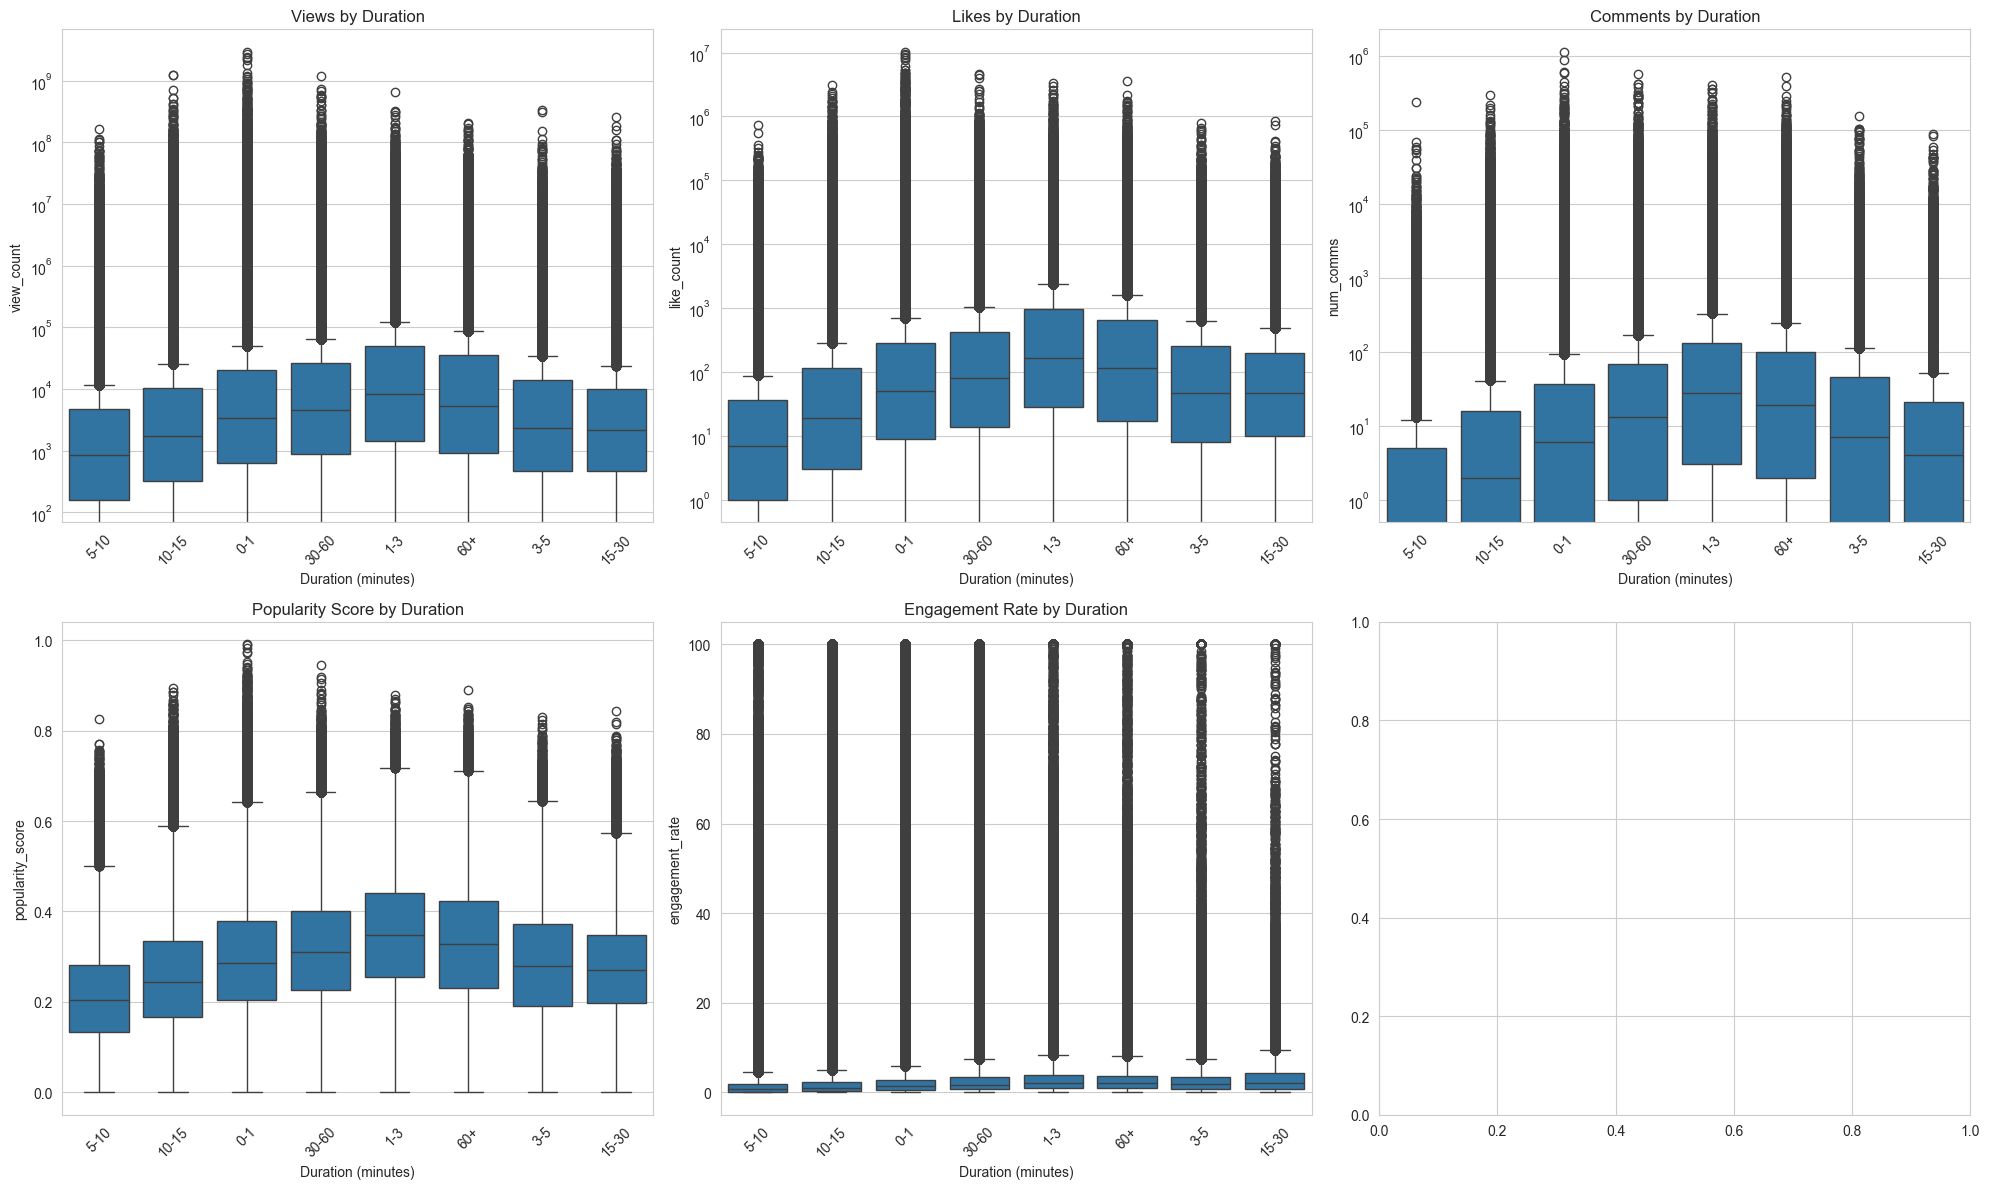

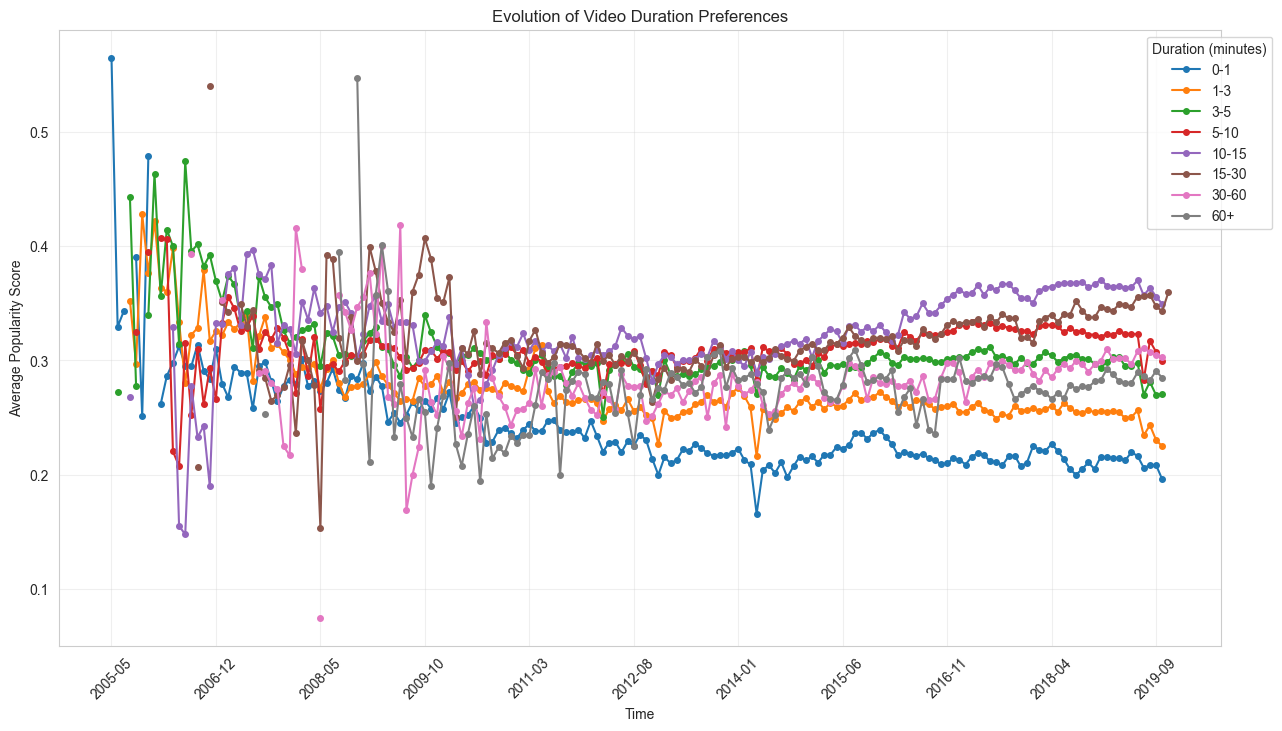

In [ ]:
def calculate_popularity_score_vectorized(df):
    """
    Vectorized calculation of popularity score
    """

    view_score = np.log1p(df['view_count'])
    like_score = np.log1p(df['like_count'])
    comment_score = np.log1p(df['num_comms'])


    max_view = np.log1p(df['view_count'].max())
    max_like = np.log1p(df['like_count'].max())
    max_comment = np.log1p(df['num_comms'].max())


    score = (
            0.5 * (view_score / max_view) +
            0.3 * (like_score / max_like) +
            0.2 * (comment_score / max_comment)
    )

    return score

def analyze_duration_metrics():
    """
    Analyze relationships between video duration and various performance metrics
    """
    # Select only needed columns for merging to reduce memory usage
    df_metadata_subset = df_metadata[['display_id', 'duration', 'view_count', 'like_count', 'upload_date']].copy()
    df_comments_subset = df_comments[['display_id', 'num_comms']].copy()

    df_analysis = pd.merge(
        df_metadata_subset,
        df_comments_subset,
        on='display_id',
        how='left'
    )

    # Convert duration to minutes
    df_analysis['duration_minutes'] = df_analysis['duration'] / 60

    # Vectorized calculation of popularity score
    df_analysis['popularity_score'] = calculate_popularity_score_vectorized(df_analysis)

    # Create duration categories
    duration_bins = [0, 1, 3, 5, 10, 15, 30, 60, np.inf]
    duration_labels = ['0-1', '1-3', '3-5', '5-10', '10-15', '15-30', '30-60', '60+']
    df_analysis['duration_category'] = pd.cut(
        df_analysis['duration_minutes'],
        bins=duration_bins,
        labels=duration_labels
    )

    return df_analysis

def plot_engagement_metrics(df_analysis):
    """
    Plot engagement metric charts
    """
    plot_data = df_analysis

    # Calculate engagement rate
    plot_data['engagement_rate'] = (plot_data['like_count'] / plot_data['view_count'] * 100).fillna(0)
    plot_data['engagement_rate'] = plot_data['engagement_rate'].clip(upper=100)

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    metrics = ['view_count', 'like_count', 'num_comms', 'popularity_score', 'engagement_rate']
    titles = ['Views by Duration', 'Likes by Duration', 'Comments by Duration', 'Popularity Score by Duration', 'Engagement Rate by Duration']

    for i, (metric, title) in enumerate(zip(metrics[:5], titles)):
        row = i // 3
        col = i % 3

        # Create box plot
        sns.boxplot(
            x='duration_category',
            y=metric,
            data=plot_data,
            ax=axes[row, col]
        )

        # Set x-axis ticks and labels correctly
        axes[row, col].set_xticks(range(len(plot_data['duration_category'].unique())))
        axes[row, col].set_xticklabels(
            plot_data['duration_category'].unique(),
            rotation=45
        )

        axes[row, col].set_title(title)
        if metric in ['view_count', 'like_count', 'num_comms']:
            axes[row, col].set_yscale('log')
        axes[row, col].set_xlabel('Duration (minutes)')

    plt.tight_layout()

    # Calculate statistics, explicitly specify observed parameter
    engagement_stats = df_analysis.groupby('duration_category', observed=True)['engagement_rate'].agg([
        'mean', 'median', 'std'
    ]).round(2)

    return fig, engagement_stats

def analyze_temporal_trends(df_analysis):
    # Pre-calculate year and month
    df_analysis['year_month'] = df_analysis['upload_date'].dt.to_period('M')

    # Explicitly specify observed parameter
    temporal_trends = (df_analysis.groupby(
        ['year_month', 'duration_category'],
        observed=True
    )['popularity_score'].mean().reset_index())

    plt.figure(figsize=(15, 8))

    # Reshape data using pivot_table
    pivot_data = temporal_trends.pivot(
        index='year_month',
        columns='duration_category',
        values='popularity_score'
    )

    # Plot trend lines
    for col in pivot_data.columns:
        if not pivot_data[col].empty:
            plt.plot(range(len(pivot_data)), pivot_data[col], label=col, marker='o', markersize=4)

    # Set x-axis labels
    step = max(len(pivot_data) // 10, 1)
    plt.xticks(
        range(0, len(pivot_data), step),
        [str(idx) for idx in pivot_data.index[::step]],
        rotation=45
    )

    plt.title('Evolution of Video Duration Preferences')
    plt.xlabel('Time')
    plt.ylabel('Average Popularity Score')
    plt.legend(title='Duration (minutes)', bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)

    return plt

# Run analysis
df_analysis = analyze_duration_metrics()
fig_engagement, stats = plot_engagement_metrics(df_analysis)
plt_trends = analyze_temporal_trends(df_analysis)